<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Final Kaggle competition ML

In [32]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score

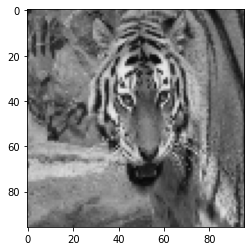

In [4]:
#PATH = './drive/MyDrive/ML-Kaggle/'
PATH = '../data/'

x_train_scalar = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_train = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))
x_test =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_train = []

for image in x_train_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_train.append(np.array(img_as_img))
    
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))

plt.imshow(np.transpose(x_train[0], (1, 2 , 0)))

In [5]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))
labels

{'big_cats': 0,
 'butterfly': 1,
 'cat': 2,
 'chicken': 3,
 'cow': 4,
 'dog': 5,
 'elephant': 6,
 'goat': 7,
 'horse': 8,
 'spider': 9,
 'squirrel': 10}

---

## Hyperparameters

In [6]:
batch_size = 64

---

## Preprocessing

---
## Model

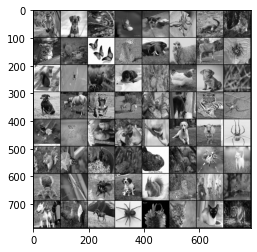

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cuda')

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)



x_train_tensor = torch.tensor(x_train,dtype=float)
y_train_tensor = torch.tensor([labels[y] for y in y_train], dtype=float)
x_test_tensor = torch.tensor(x_test, dtype=float)



trans = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False)

#x_train_tensor.shape
real_batch = next(iter(dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:


conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,5)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)
print("")

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)
print("")

x = pool(x)
print("POOL2")
print(x.shape)
print("")

images
torch.Size([64, 3, 96, 96])

CONV1
torch.Size([64, 6, 92, 92])

POOL1
torch.Size([64, 6, 46, 46])

CONV2
torch.Size([64, 16, 42, 42])

POOL2
torch.Size([64, 16, 21, 21])



In [26]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(2,2)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(6,16,5) 
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*21*21, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*21*21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
running_loss = 0 
printfreq = 50
for epoch in tqdm.tqdm(range(50)):
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.long()
        optimizer.zero_grad()
        outputs = net(inputs)  # forward pass 
        outputs = outputs.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            running_loss = 0 

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

0 50 2.546269040107727
0 100 2.35166558265686
0 150 2.3344738578796385


  2%|█▋                                                                                 | 1/50 [00:18<15:11, 18.61s/it]

1 50 3.9989291334152224
1 100 2.320846643447876
1 150 2.301996250152588


  4%|███▎                                                                               | 2/50 [00:36<14:22, 17.97s/it]

2 50 3.941838002204895
2 100 2.26546395778656
2 150 2.171324059963226


  6%|████▉                                                                              | 3/50 [00:54<14:07, 18.03s/it]

3 50 3.7365856695175172
3 100 2.0907657384872436
3 150 2.0303557324409485


  8%|██████▋                                                                            | 4/50 [01:12<13:44, 17.93s/it]

4 50 3.463531858921051
4 100 2.0288578724861144
4 150 1.906433687210083


 10%|████████▎                                                                          | 5/50 [01:29<13:26, 17.92s/it]

5 50 3.282771973609924
5 100 1.9110794401168822
5 150 1.784848041534424


 12%|█████████▉                                                                         | 6/50 [01:48<13:12, 18.02s/it]

6 50 3.064588341712952
6 100 1.7624000573158265
6 150 1.6745423197746276


 14%|███████████▌                                                                       | 7/50 [02:06<13:00, 18.14s/it]

7 50 2.842670130729675
7 100 1.6048263454437255
7 150 1.5148799848556518


 16%|█████████████▎                                                                     | 8/50 [02:24<12:33, 17.95s/it]

8 50 2.494127711057663
8 100 1.348560242652893
8 150 1.360732536315918


 18%|██████████████▉                                                                    | 9/50 [02:41<12:10, 17.82s/it]

9 50 2.1828349268436433
9 100 1.2476041746139526
9 150 1.249201889038086


 20%|████████████████▍                                                                 | 10/50 [02:59<11:48, 17.72s/it]

10 50 1.8876006782054902
10 100 1.2098478722572326
10 150 1.113870483636856


 22%|██████████████████                                                                | 11/50 [03:17<11:34, 17.81s/it]

11 50 1.7734758710861207
11 100 1.1174301457405091
11 150 0.9580565989017487


 24%|███████████████████▋                                                              | 12/50 [03:35<11:20, 17.90s/it]

12 50 1.6458357220888138
12 100 1.1122996735572814
12 150 0.8882737112045288


 26%|█████████████████████▎                                                            | 13/50 [03:53<11:03, 17.92s/it]

13 50 1.344174433350563
13 100 1.03958460688591
13 150 0.7370594096183777


 28%|██████████████████████▉                                                           | 14/50 [04:10<10:41, 17.81s/it]

14 50 1.0967641979455949
14 100 0.8961490720510483
14 150 0.6269587498903274


 30%|████████████████████████▌                                                         | 15/50 [04:28<10:21, 17.76s/it]

15 50 1.158414787054062
15 100 0.7043151491880417
15 150 0.60022306650877


 32%|██████████████████████████▏                                                       | 16/50 [04:46<10:04, 17.78s/it]

16 50 1.0718435031175613
16 100 0.5835697561502456
16 150 0.4350992634892464


 34%|███████████████████████████▉                                                      | 17/50 [05:03<09:44, 17.73s/it]

17 50 0.6891847595572471
17 100 0.42616041988134384
17 150 0.3439478212594986


 36%|█████████████████████████████▌                                                    | 18/50 [05:21<09:22, 17.59s/it]

18 50 0.7328537687659263
18 100 0.3887236620485783
18 150 0.41459445461630823


 38%|███████████████████████████████▏                                                  | 19/50 [05:39<09:09, 17.74s/it]

19 50 1.0084213376045228
19 100 0.4444297060370445
19 150 0.40185983598232267


 40%|████████████████████████████████▊                                                 | 20/50 [05:56<08:50, 17.68s/it]

20 50 0.5818823692202568
20 100 0.4706934632360935
20 150 0.39111982837319376


 42%|██████████████████████████████████▍                                               | 21/50 [06:14<08:31, 17.65s/it]

21 50 0.5090250814706088
21 100 0.3614484114199877
21 150 0.5572514982521534


 44%|████████████████████████████████████                                              | 22/50 [06:32<08:16, 17.72s/it]

22 50 0.38337587885558605
22 100 0.3542743580788374
22 150 0.3544397836923599


 46%|█████████████████████████████████████▋                                            | 23/50 [06:50<07:59, 17.76s/it]

23 50 0.23356740396469833
23 100 0.1867053647339344
23 150 0.12662083214148878


 48%|███████████████████████████████████████▎                                          | 24/50 [07:09<07:52, 18.17s/it]

24 50 0.16525242932140827
24 100 0.09179679218679666
24 150 0.04721329645719379


 50%|█████████████████████████████████████████                                         | 25/50 [07:27<07:33, 18.16s/it]

25 50 0.09809281612280757
25 100 0.05588043457828462
25 150 0.02930747059173882


 52%|██████████████████████████████████████████▋                                       | 26/50 [07:45<07:17, 18.25s/it]

26 50 0.052821757742203775
26 100 0.0404234566912055
26 150 0.02566891348338686


 54%|████████████████████████████████████████████▎                                     | 27/50 [08:04<06:59, 18.26s/it]

27 50 0.038645158039871605
27 100 0.0393551535718143
27 150 0.0161339723598212


 56%|█████████████████████████████████████████████▉                                    | 28/50 [08:22<06:41, 18.26s/it]

28 50 0.026350512656499632
28 100 0.0522839683573693
28 150 0.01884730170480907


 58%|███████████████████████████████████████████████▌                                  | 29/50 [08:40<06:20, 18.11s/it]

29 50 0.02983650302630849
29 100 0.037202394844498485
29 150 0.034737105986569074


 60%|█████████████████████████████████████████████████▏                                | 30/50 [08:57<06:00, 18.05s/it]

30 50 0.05851514151203446
30 100 0.03811263511655852
30 150 0.024179930991958826


 62%|██████████████████████████████████████████████████▊                               | 31/50 [09:18<05:57, 18.81s/it]

31 50 0.04521620897925459
31 100 0.036319338725879786
31 150 0.042311995564959945


 64%|████████████████████████████████████████████████████▍                             | 32/50 [09:39<05:52, 19.57s/it]

32 50 0.04762792230234481
32 100 0.03159127465914935
32 150 0.017024831251474096


 66%|██████████████████████████████████████████████████████                            | 33/50 [10:00<05:36, 19.77s/it]

33 50 0.037090091941063295
33 100 0.021128607114078476
33 150 0.027488704387214968


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [10:19<05:15, 19.70s/it]

34 50 0.044144912492483854
34 100 0.029455694673524702
34 150 0.024237104513449594


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [10:38<04:50, 19.40s/it]

35 50 0.020028809824143536
35 100 0.012209617535991129
35 150 0.007523982039128896


 72%|███████████████████████████████████████████████████████████                       | 36/50 [10:58<04:33, 19.56s/it]

36 50 0.012332718474790455
36 100 0.006920629927772097
36 150 0.005990162400412374


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [11:16<04:10, 19.26s/it]

37 50 0.003924540829029865
37 100 0.005631164115620777
37 150 0.005299866714776727


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [11:36<03:51, 19.31s/it]

38 50 0.0034797193113627143
38 100 0.002947453464003047
38 150 0.002971420713001862


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [11:55<03:30, 19.14s/it]

39 50 0.0035741714793402933
39 100 0.0007130653737840476
39 150 0.0008345227746031015


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [12:13<03:09, 18.97s/it]

40 50 0.0015943874054573826
40 100 0.00047261798579711467
40 150 0.0011011693882937833


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [12:31<02:48, 18.72s/it]

41 50 0.004383693935815245
41 100 0.0004925242425088072
41 150 0.0003334477713724482


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [12:51<02:32, 19.08s/it]

42 50 0.0003005752796616434
42 100 0.00014807881569140591
42 150 0.00012508280762631329


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [13:11<02:15, 19.42s/it]

43 50 0.00020495656535786112
43 100 0.00012004114207229577
43 150 0.00010369167932367418


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [13:31<01:57, 19.54s/it]

44 50 0.00017230110008313205
44 100 0.0001045027586951619
44 150 8.960423940152396e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [13:50<01:36, 19.26s/it]

45 50 0.00015097988128673023
45 100 9.337276456790278e-05
45 150 7.979520285516628e-05


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [14:08<01:15, 18.98s/it]

46 50 0.00013523210007406305
46 100 8.449632392512285e-05
46 150 7.206975928056636e-05


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [14:26<00:56, 18.69s/it]

47 50 0.00012293937451886449
47 100 7.747665222268552e-05
47 150 6.592271874978905e-05


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [14:44<00:36, 18.42s/it]

48 50 0.00011307613238841441
48 100 7.144172417611116e-05
48 150 6.0902692948729966e-05


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [15:02<00:18, 18.24s/it]

49 50 0.00010490066329566617
49 100 6.647149995842483e-05
49 150 5.6645887134436635e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [15:20<00:00, 18.40s/it]


In [29]:
inputs, labels = next(iter(dataloader))
outputs = net(inputs.float())

preds = outputs.argmax(dim=1)

In [30]:
print(preds)

tensor([ 0,  5, 10,  9,  5,  9, 10,  0,  0, 10,  1,  0,  6,  7,  4,  9, 10,  9,
        10,  5,  9,  3,  5,  1,  5,  8,  5,  4,  9,  5,  0,  9,  1,  0,  2,  8,
        10,  5,  4,  9, 10,  1,  5,  9,  3, 10,  9,  2, 10,  9,  9,  5, 10,  0,
         5, 10,  5,  3,  8,  9,  9,  2,  2,  0])


In [31]:
print(labels)

tensor([ 0.,  5., 10.,  9.,  5.,  9., 10.,  0.,  0., 10.,  1.,  0.,  6.,  7.,
         4.,  9., 10.,  9., 10.,  5.,  9.,  3.,  5.,  1.,  5.,  8.,  5.,  4.,
         9.,  5.,  0.,  9.,  1.,  0.,  2.,  8., 10.,  5.,  4.,  9., 10.,  1.,
         5.,  9.,  3., 10.,  9.,  2., 10.,  9.,  9.,  5., 10.,  0.,  5., 10.,
         5.,  3.,  8.,  9.,  9.,  2.,  2.,  0.], dtype=torch.float64)


In [33]:
accuracy_score(labels, preds)

1.0

In [35]:
for i, data in enumerate(dataloader):
    inputs, labels = data
    outputs = net(inputs.float())

    preds = outputs.argmax(dim=1)
    print(accuracy_score(labels, preds))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
